In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Подключение к БД

В файле `config/.env` необходимо задать все параметры для подключения к бд

In [2]:
# путь к конфигурационному файлу
load_dotenv('../config/.env')
    
config = {
        'host': os.getenv('DB_HOST'),
        'user': os.getenv('DB_USER'),
        'password': os.getenv('DB_PASSWORD'),
        'database': os.getenv('DB_NAME'),
        'port': os.getenv('DB_PORT', 3306)
    }


In [3]:
connection_string = (f"mysql+mysqlconnector://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")

Поскольку запросы в ноутбуке выполняются с перерывами, подключение может быть разорвано. Поэтому каждый запрос обернем в функцию, которая возобновляет подключение:

In [4]:
def get_query(query):
    """Создает новое подключение для каждого запроса"""
    engine = create_engine(connection_string)
    try:
        with engine.connect() as conn: 
            result = pd.read_sql_query(query, conn)
            return result
    finally:
        engine.dispose()  # Важно: закрываем engine

## Аналитика

### 1. Количество пользователей, которые ни разу не заходили в систему

In [5]:
query_1 = """SELECT COUNT(*) as Amount
             FROM users
            WHERE last_visited_step_id IS NULL"""

result_1  = get_query(query_1)


print(f'Количество пользователей, которые никогда не заходили в систему: {result_1.iat[0,0]}')

Количество пользователей, которые никогда не заходили в систему: 22


###  2. Количество пользователей, которые заходили в систему, но ничего не пытались решить

In [6]:
query_2 = """SELECT COUNT(id) as Amount
FROM users
WHERE last_visited_step_id IS NOT NULL AND id NOT IN 
(SELECT DISTINCT user_id  FROM solutions)"""

result_2  = get_query(query_2)
print(f'Количество пользователей, которые заходили в систему, но ничего не пытались решить: {result_2.iat[0,0]}')

Количество пользователей, которые заходили в систему, но ничего не пытались решить: 7


### 3. Рейтинг студентов
Теперь не бездельники: таблица с количеством правильно решенных заданий и количество попыток решений (неважно, правильных в итоге или нет) для каждого пользователя

In [7]:
query_3 = """SELECT first.login, first.attempts_total, second.completed_steps
FROM
(SELECT u.login, SUM(s.attempts_count) AS attempts_total
FROM solutions s
LEFT JOIN users u ON s.user_id = u.id
GROUP BY s.user_id) AS first LEFT JOIN    -- суммарное количество попыток решений
(SELECT u.login, COUNT(step_id) AS completed_steps
 FROM solutions s
 LEFT JOIN users u ON s.user_id = u.id
 WHERE is_correct = 1
 GROUP BY s.user_id) AS second            -- количество решенных заданий
 ON first.login = second.login
 ORDER BY completed_steps DESC"""
result_3 = get_query(query_3)
result_3

,login,attempts_total,completed_steps
0,admin,155.0,44
1,test,36.0,6
2,okrylovich,1.0,1


### 4. Аналитика по степам
Количество попыток, правильных решений (= количество решивших пользователей), доля правильных решений из всех попыток для каждого степа, среднее количество попыток решений для каждого степа. Отфильтрованы только с малой долей правильных решений (<30%). К степам также добавлены названия уроков

In [8]:
query_4 = """SELECT lessons.title as lesson, steps_category.title, steps.id as step,
SUM(solutions.attempts_count) as attempts_total, SUM(solutions.is_correct) as correct_total,
ROUND(SUM(solutions.is_correct) / SUM(solutions.attempts_count) * 100, 1) as proportion_of_correct,
ROUND(AVG(solutions.attempts_count), 1) AS average_attempts_amount

FROM steps
LEFT JOIN solutions ON steps.id = solutions.step_id
LEFT JOIN lessons on steps.lesson_id = lessons.id
LEFT JOIN steps_category on steps.category_id = steps_category.id
WHERE steps.category_id != 1
GROUP BY steps.id
HAVING proportion_of_correct < 30
ORDER BY proportion_of_correct
"""

result_4 = get_query(query_4)

result_4

,lesson,title,step,attempts_total,correct_total,proportion_of_correct,average_attempts_amount
0,Pandas. Практическая работа,Загрузка файла,51,30.0,2.0,6.7,15.0
1,Фильтрация и сортировка,Загрузка файла,65,12.0,1.0,8.3,12.0
2,Pandas. Практическая работа,Текстовый ответ,50,22.0,2.0,9.1,11.0
3,Группировка и агрегация,Загрузка файла,78,7.0,1.0,14.3,7.0
4,Pandas. Практическая работа,Текстовый ответ,49,6.0,1.0,16.7,3.0
5,Группировка и агрегация,Текстовый ответ,72,6.0,1.0,16.7,6.0
6,"""Длинный"" и ""широкий"" формат",Загрузка файла,81,6.0,1.0,16.7,6.0
7,Работа со столбцами,Загрузка файла,71,5.0,1.0,20.0,5.0
8,Группировка и агрегация,Загрузка файла,77,5.0,1.0,20.0,5.0
9,Группировка и агрегация,Загрузка файла,75,4.0,1.0,25.0,4.0


#### 4.1. Зависимость успеха решений от количества попыток для каждого шага.
Как видим, сложные задания (с низким % верных решений) имеют больше всего попыток решений.

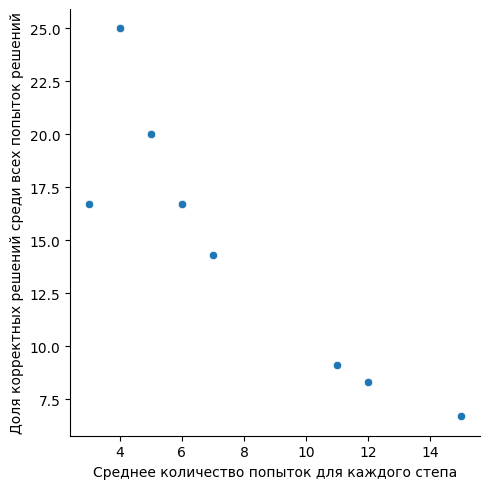

In [ ]:
figure_4 = sns.relplot(result_4, x = 'average_attempts_amount', y = 'proportion_of_correct')
figure_4.set_ylabels('Доля корректных решений среди всех попыток решений')
figure_4.set_xlabels('Среднее количество попыток для каждого степа')


### 5. В каком уроке меньше всего доля верных решений из всех попыток?

In [54]:
query_5 = """SELECT sections.title as section, lessons.title as lesson, 
SUM(solutions.attempts_count) as attempts_total,
SUM(solutions.is_correct) as correct_total, 
ROUND(SUM(solutions.is_correct) / SUM(solutions.attempts_count) * 100, 0) as proportion_of_correct
FROM steps
LEFT JOIN solutions ON steps.id = solutions.step_id
LEFT JOIN lessons on steps.lesson_id = lessons.id
LEFT JOIN sections ON lessons.section_id = sections.id
WHERE steps.category_id != 1
GROUP BY lesson
ORDER BY proportion_of_correct -- пропорция верно решенных заданий"""


result_5 = get_query(query_5)
result_5

,section,lesson,attempts_total,correct_total,proportion_of_correct
0,Основы Pandas,Фильтрация и сортировка,18.0,3.0,17.0
1,Основы Pandas,Pandas. Практическая работа,79.0,16.0,20.0
2,Основы Pandas,Группировка и агрегация,29.0,7.0,24.0
3,Основы Pandas,"""Длинный"" и ""широкий"" формат",19.0,5.0,26.0
4,Основы Pandas,Работа со столбцами,13.0,4.0,31.0
5,Основы Pandas,Конспект и другие полезные темы,6.0,2.0,33.0
6,Основы Pandas,Объединение таблиц,21.0,10.0,48.0
7,Основы Pandas,Визуализация,2.0,1.0,50.0
8,Основы Pandas,Импорт и экспорт данных,5.0,3.0,60.0


### 6. Шаги, которые никто никогда не проходил и не просматривал
(за исключением админа, который в любом случае проверяет все степы)

In [9]:
query_6 = """SELECT lessons.title as lesson, steps.id as step_id
FROM steps
LEFT JOIN lessons ON steps.lesson_id = lessons.id
WHERE steps.id NOT IN (SELECT DISTINCT(step_views.step_id)
				 FROM step_views
				 LEFT JOIN users ON step_views.user_id = users.id 
				 WHERE users.login != 'admin')                      
AND steps.id NOT IN (SELECT DISTINCT solutions.step_id
			   FROM solutions
			   LEFT JOIN users ON solutions.user_id = users.id
			   WHERE users.login != 'admin')"""

result_6 = get_query(query_6)

result_6

,lesson,step_id
0,Импорт и экспорт данных,12
1,Фильтрация и сортировка,17
2,Фильтрация и сортировка,18
3,Фильтрация и сортировка,19
4,Фильтрация и сортировка,20
5,Фильтрация и сортировка,65
6,Фильтрация и сортировка,66
7,Фильтрация и сортировка,67
8,Работа со столбцами,22
9,Работа со столбцами,23
